<a href="https://colab.research.google.com/github/dhruv-pandit/PRA3024/blob/main/CNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some data-handling functions to download/import.

#from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


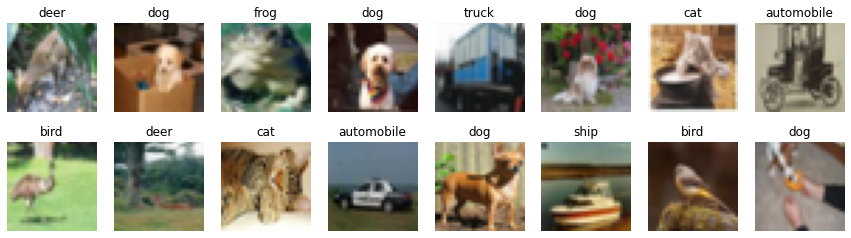

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [7]:
def make_model():
    #here is the model that i built 
  
    model = Sequential()
 
    # first block
    model.add(Conv2D(32, kernel_size=(3, 3) , kernel_initializer='he_uniform', input_shape=(32,32,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    # second block
    model.add(Conv2D(64, kernel_size=(3, 3) , kernel_initializer='he_uniform', padding='same', activation='relu')) #increasing filters 
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    

    # third block
    model.add(Conv2D(128, kernel_size=(3, 3) , kernel_initializer='he_uniform', padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
    

    # flattening followed by dense layer and final output layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    Dropout(0.5)
    model.add(LeakyReLU(0.1))
    model.add(Dense(10,activation='softmax'))

    return model  

In [8]:

INIT_LR = 0.005  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 25 #i changed this to 10


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
	# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=64)

# fit model
history = model.fit(
    it_train, # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)


# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/25
625/625 [==============================] - 53s 32ms/step - loss: 1.8286 - accuracy: 0.3462 - val_loss: 1.4756 - val_accuracy: 0.4951
Epoch 2/25
625/625 [==============================] - 19s 31ms/step - loss: 1.3161 - accuracy: 0.5177 - val_loss: 1.2062 - val_accuracy: 0.5639
Epoch 3/25
625/625 [==============================] - 20s 31ms/step - loss: 1.1213 - accuracy: 0.5984 - val_loss: 1.0404 - val_accuracy: 0.6498
Epoch 4/25
625/625 [==============================] - 20s 32ms/step - loss: 0.9806 - accuracy: 0.6520 - val_loss: 0.8376 - val_accuracy: 0.7074
Epoch 5/25
625/625 [==============================] - 20s 31ms/step - loss: 0.8706 - accuracy: 0.6956 - val_loss: 0.8123 - val_accuracy: 0.7231
Epoch 6/25
625/625 [==============================] - 20s 32ms/step - loss: 0.8154 - accuracy: 0.7135 - val_loss: 0.9053 - val_accuracy: 0.6924
Epoch 7/25
625/625 [==============================] - 20s 31ms/step - loss: 0.7693 - accuracy: 0.7284 - val_loss: 0.7520 - val_accuracy:

In [9]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

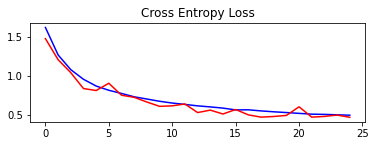

In [10]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')


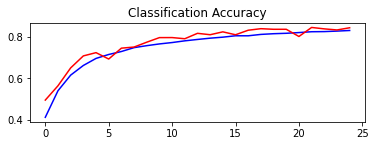

In [11]:
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='test')

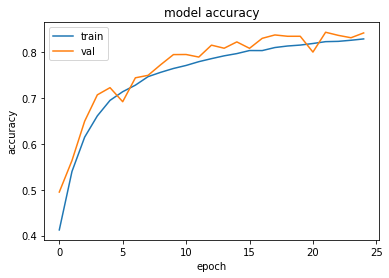

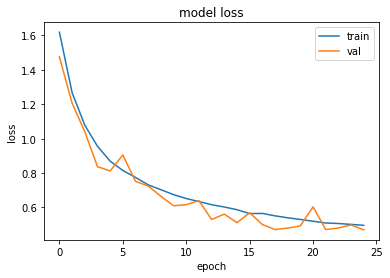

In [12]:
#  Ploting the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()
# Ploting the loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()
#code obtained from https://makecodelucid.blogspot.com/2020/08/cifar-10-classification-cnn-keras.html

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


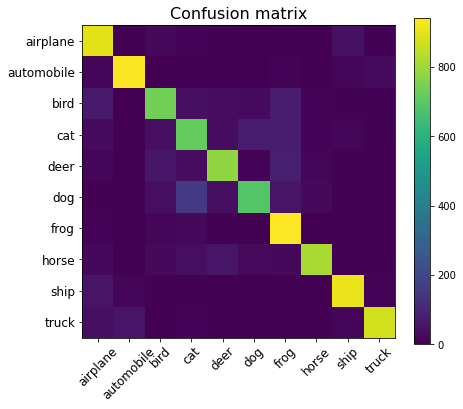

Test accuracy: 0.8317


In [13]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

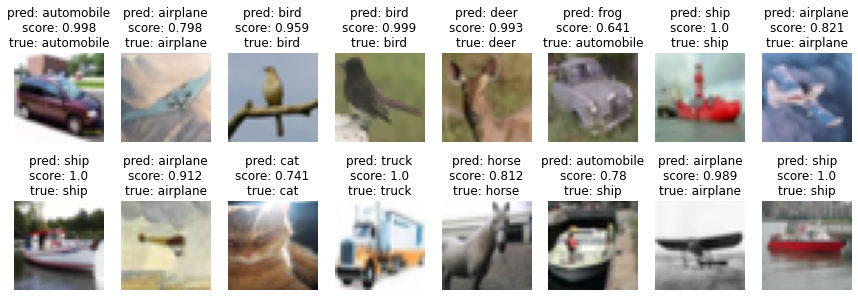

In [14]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [15]:
from sklearn.metrics import   classification_report
import numpy as np
classification_report_final = classification_report(y_test_index, y_pred_test_classes)


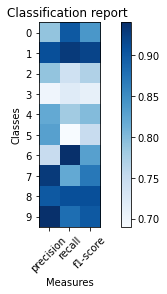

In [16]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        if(len(t)==0):   
                    break 
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

plot_classification_report(classification_report_final)

#code obtained from https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report

I have modelled by CNN based on the CNN created here https://makecodelucid.blogspot.com/2020/08/cifar-10-classification-cnn-keras.html.

In this model I am stacking CNNs to form blocks, which are then repeated with increasnig number of filters and depth. I found that three blocks was a good stopping point since i was able to achieve 80+percent accuracy
Each layer utilises the ReLu activation function.

It also has a dropout layer that increases at each block since that was shown to increase the accuracy over a fixed dropout level and increase the regularisation.

The dataset provided was also augmented to expand the dataset. 
Batch normalisation was also added to stablise the model. 

An initial learning rate of 0.001 was selected as it was shown to be good, but was later increased to 0.005. Batch size was increases from 32 to 64, and the number of epochs was slowly increased in bathches of five from an initial value of 5 to 25. 
The images were flipped and shifted using ImageDataGenerator. 

    